### Requirements

In [1]:
from functions.helping_functions import *
from functions.Financials import *
from functions.deployment_functions import *

In [2]:
from shapely.geometry import Point
import os
import csv
import pyproj
import geopy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import folium
import geopandas as gpd
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.pipeline import make_pipeline
from shapely.geometry import shape
import geocoder
import math
import datetime

In [3]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [9]:
df_routes = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\D-routes-2022.csv", on_bad_lines='skip', sep=';')
df_tmja = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\E-tmja-2019.csv", on_bad_lines='skip', sep=';')
df_station = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\I-Donne╠ües de stations TE_DV.xlsx - export_data_te.csv")

In [10]:
df_routes = pd.DataFrame(df_routes)
df_tmja = pd.DataFrame(df_tmja)

#### TMJA

In [11]:
def add_lat_lon_columns(df):
    """
    Adds new columns 'lonD', 'latD', 'lonF', 'latF' to the dataframe with
    corresponding latitude and longitude values based on the 'xD', 'yD', 'xF',
    and 'yF' columns, which are in Lambert-93 projection.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the columns 'xD', 'yD', 'xF', and 'yF'.

    Returns:
    --------
    pandas.DataFrame
        The original dataframe with the new 'lonD', 'latD', 'lonF', and 'latF'
        columns added.
    """
    # Define the input and output projections
    in_proj = pyproj.Proj(init='epsg:2154')  # Lambert-93
    out_proj = pyproj.Proj(init='epsg:4326')  # WGS84

    df['xD'] = df['xD'].str.replace(',', '.')
    df['yD'] = df['yD'].str.replace(',', '.')
    df['xF'] = df['xF'].str.replace(',', '.')
    df['yF'] = df['yF'].str.replace(',', '.')

    # Convert start coordinates to lat-long
    df['lonD'], df['latD'] = pyproj.transform(in_proj, out_proj, df['xD'], df['yD'])

    # Convert end coordinates to lat-long
    df['lonF'], df['latF'] = pyproj.transform(in_proj, out_proj, df['xF'], df['yF'])

    return df

### Stations Analysis

In [12]:
def remove_dom_tom(df:pd.DataFrame)-> pd.DataFrame:
    '''
    Removes idenfied Dom Tom data from our database
    '''
    mask = df["Adresse"].str.contains("GUYANNE|REUNION|MARTINIQUE|GUADELOUPE|FORT DE FRANCE| LA SALLE LES ALPES")
    df = df[~mask]
    return df

In [13]:
df_station = remove_dom_tom(df_station)

In [14]:
# Remove DOM TOM``
mask = df_station["Adresse"].str.contains("GUYANNE|REUNION|MARTINIQUE|GUADELOUPE|FORT DE FRANCE| LA SALLE LES ALPES")
df_station = df_station[~mask]

In [15]:
print(df_station['Adresse'].str.contains("Guyane").sum())
print(df_station['Adresse'].str.contains("Reunion").sum())

0
0


In [16]:
df_station['Coordinates'] = df_station['Coordinates'].apply(lambda x: x.replace(',,', ','))

In [17]:
df_station['Coordinates'].apply(lambda x: x.split(',')[1]).min()

' -0.08951268605788969'

In [18]:
def add_lat_long(df:pd.DataFrame)-> pd.DataFrame:
    '''
    Add Longitude and Latitude columns based on Coordiantes columnb
    '''
    df_station['latitude'] = df_station['Coordinates'].apply(lambda x: x.split(',')[0]).astype(float)
    df_station['longitude'] =df_station['Coordinates'].apply(lambda x: x.split(',')[1]).astype(float)
    return df_station

In [19]:
df_station = add_lat_long(df_station)

### Logistic Hubs

In [20]:
# import data
df_Logistic = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\Donne_Logistique\Donnee_Logistique.csv")
df_Logistic_regional = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\Donne_Logistique\Donnee_regionale.csv")
Logistic_shape = gpd.read_file(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\HEC_air_liquide\data\F-aire-logistiques-donnees-detaillees\Aires_logistiques_denses.shp")

In [21]:
df_Logistic = df_Logistic.rename(columns ={'Identifiant aire logistique dense (e1)':'e1'})
df_Logistic['e1'].nunique()

387

In [22]:
df_Logistic = df_Logistic.merge(Logistic_shape,on='e1')
df_Logistic

,e1,Région d'implantation,Numéro aires dans région,Communes concernées par l'aire logistique,Nombre d'EPL de plus de 5 000 m2,Surface totale,P_Transport_et_entreposage,P_commerce,P_industrie,P_autres,Eff_com_entreposage,EFF_EPL_5000,Poids de l'entreposage,Chargement,Déchargement,geometry
0,1,52,3,"Saint-Nazaire, Montoir-de-Bretagne, Trignac",Oct-19,155000,0.600000,0.100000,0.300000,0.000000,1800,300,0.045252971,30,30,"POLYGON ((306902.300 6698606.120, 306928.370 6..."
1,11,52,19,Saint-Sylvain-d'Anjou,03-Sep,50000,0.333333,0.666667,0.000000,0.000000,NC,NC,NC,NC,NC,"POLYGON ((438799.329 6718105.186, 437358.871 6..."
2,12,24,4,"Parçay-Meslay, Tours",03-Sep,142000,0.444444,0.333333,0.222222,0.000000,NC,NC,NC,NC,NC,"POLYGON ((526362.570 6705773.465, 526295.674 6..."
3,16,52,20,Seiches-sur-le-Loir,03-Sep,36000,0.000000,0.333333,0.333333,0.333333,NC,NC,NC,NC,NC,"POLYGON ((447653.710 6724311.330, 448966.997 6..."
4,20,52,2,"Saint-Barthélemy-d'Anjou, Angers, Écouflant",Oct-19,247000,0.529412,0.352941,0.058824,0.058824,1900,300,0.022601958,30,30,"POLYGON ((434053.600 6713607.200, 434053.600 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,7615,53,25,Quimper,03-Sep,23000,0.000000,1.000000,0.000000,0.000000,NC,NC,NC,NC,NC,"POLYGON ((172430.500 6789897.180, 172504.930 6..."
378,7883,84,33,Pusignan,03-Sep,52000,0.500000,0.250000,0.000000,0.250000,NC,NC,NC,NC,NC,"POLYGON ((860697.140 6518129.670, 860759.800 6..."
379,8251,24,30,Chécy,03-Sep,50000,0.333333,0.333333,0.000000,0.333333,NC,NC,NC,NC,NC,"POLYGON ((628243.590 6755956.120, 628045.360 6..."
380,9337,11,31,"Chanteloup-en-Brie, Chessy, Jossigny, Montévrain",03-Sep,61000,0.250000,0.250000,0.000000,0.500000,NC,NC,NC,NC,NC,"POLYGON ((682949.150 6861042.150, 681716.102 6..."


In [23]:
df_Logistic.iloc[:,4].apply(lambda x: datetime.datetime.strptime(x, '%b-%y').strftime('%m-%y'))

ValueError: time data '03-Sep' does not match format '%b-%y'

In [ ]:
#df_Logistic.head()

In [ ]:
address = df_Logistic['Communes concernées par l\'aire logistique'][0]
g = geocoder.arcgis(address,country = 'France')
lat, lng = g.latlng
print("Latitude: ", lat)
print("Longitude:", lng)

In [ ]:
Logistic_shape

In [ ]:
# Too many towns make the geolocalization algorithm crash
df_Logistic['Communes concernées par l\'aire logistique'][290] = 'Genneviliers'
df_Logistic['Communes concernées par l\'aire logistique'][290]

Strategy :
Limit the model to 3 region
Create scoring system based on multiple criterias. Scoring system is an f(x,y) function with x lat, y long. Constraints are not yet to be defined but include distance to logistic hub, traffic on road, pop dens,..




### Financials

In [52]:
results = pd.read_csv(r"C:\Users\cesar\Dropbox\My PC (LAPTOP-GU3S2J8B)\Downloads\results_stations_2030_part_3_1.csv")

In [33]:
results.shape

(365, 26)

In [21]:
results = sales(results,2030)

In [ ]:
threshold()

,station_type,capex,depreciation,opex,storage,construction_time,footprint,prof_threshold,threshold
0,small,3,0.15,0.30,2,1,650,0.9,1.8
1,medium,5,0.15,0.40,3,1,900,0.8,2.4
2,large,8,0.15,0.56,4,1,1200,0.6,2.4


In [15]:
results = sales(results,2030)

<Axes: >

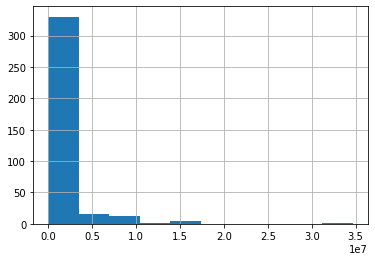

In [54]:
results['Quantity_sold_per_year(in kg)'].hist()

<Axes: >

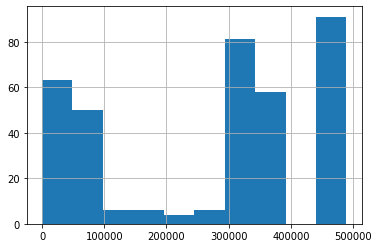

In [55]:
results['TMJA_PL'].hist()

In [73]:
def sales(df_station:pd.DataFrame, year: float)-> pd.DataFrame:
    '''
    This functions calculates the amount sold at each new stations in kg/day.
    '''
    h2_price_dict = {2023: 10, 2030: 7, 2040: 4}
    total_demands = {2030: 1110000, 2040: 1110000}
    total_demand = total_demands[year]

    if year not in h2_price_dict:
        raise ValueError('Year can only be 2023, 2030 or 2040')
    
    
    df_station['percentage_traffic'] = df_station['TMJA_PL'] / df_station['TMJA_PL'].sum()
    
    df_station['Quantity_sold_per_day(in kg)'] = total_demand * df_station['percentage_traffic'] 
    df_station['Revenues_day'] = df_station['Quantity_sold_per_day(in kg)']  * h2_price_dict[year]
    return df_station

In [74]:
results = sales(results,2030)

1.0


<Axes: >

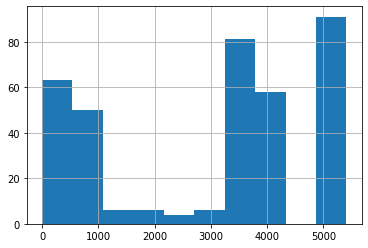

In [81]:
results['Quantity_sold_per_day(in kg)'].hist()

In [76]:
c[c['Quantity_sold_per_year(in kg)']==c['Quantity_sold_per_year(in kg)'].max()]

,Unnamed: 0,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,...,percentage_traffic,Region,Quantity_sold_per_day(in kg),Revenues_day,Quantity_sold_per_year(in kg),not_prof,small_station,medium_station,large_station,station_type
50,2032,2032,638001.098217,6.879399e+06,A0015,POINT (638001.098217033 6879398.613767712),1.0,0 1100.626099\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0.00118,Hauts-de-France,1309.512017,9166.584119,238985.943101,1,0,0,0,not profitable
59,2039,2039,634829.291971,6.881812e+06,A0015,POINT (634829.2919714977 6881811.606493512),1.0,0 99.838607\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0.00118,Hauts-de-France,1309.512017,9166.584119,238985.943101,1,0,0,0,not profitable


In [77]:
def station_type(df_station:pd.DataFrame, df_station_info: pd.DataFrame = df_station_info)-> pd.DataFrame:
    '''
    This function derives the station size depending on quantity sold and the profitability thresholds
    '''
    info = threshold()
    small_prof_threshold, medium_prof_threshold, large_prof_threshold = info['threshold']*365
    print(small_prof_threshold, medium_prof_threshold, large_prof_threshold )
    df_station['Quantity_sold_per_year(in kg)']= df_station['Quantity_sold_per_day(in kg)']*365

    df_station['not_prof'] = (df_station['Quantity_sold_per_year(in kg)']/1000< small_prof_threshold).astype(int)

    df_station['small_station'] = ((df_station['Quantity_sold_per_year(in kg)']/1000 >= small_prof_threshold) &
                                   (df_station['Quantity_sold_per_year(in kg)']/1000 < medium_prof_threshold)).astype(int)
    
    df_station['medium_station'] = ((df_station['Quantity_sold_per_year(in kg)']/1000 >= medium_prof_threshold) &
                                    (df_station['Quantity_sold_per_year(in kg)']/1000 < large_prof_threshold)).astype(int)
    
    df_station['large_station'] = (df_station['Quantity_sold_per_year(in kg)']/1000 >= large_prof_threshold).astype(int)
    
    df_station['station_type'] = df_station.apply(lambda row: 
    'not profitable' if row['not_prof'] == 1 
    else 'small' if row['small_station'] == 1 
    else 'medium' if row['medium_station'] == 1 
    else 'large' if row['large_station'] == 1 
    else 'unknown', axis=1)
    df_station.loc[df_station['station_type'] == 'not profitable', 'station_type'] = 'small'
    return df_station

In [78]:
c = station_type(results,df_factory_info)
c['station_type'].value_counts()

657.0 876.0000000000001 876.0


large             236
not profitable    125
small               4
Name: station_type, dtype: int64

In [82]:
c.loc[c['station_type'] == 'not profitable', 'station_type'] = 'small'

In [83]:
c['station_type'].value_counts()

large    236
small    129
Name: station_type, dtype: int64

In [34]:
small_prof_threshold = 600
(results['Quantity_sold_per_year(in kg)']/1000> small_prof_threshold)

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
363    False
364    False
Name: Quantity_sold_per_year(in kg), Length: 365, dtype: bool

In [18]:
c['percentage_traffic'].sum()

1.0

In [23]:
b = financials(results,2030,df_station_info)
b['station_type'].value_counts()

not profitable    326
large              30
small               9
Name: station_type, dtype: int64

In [19]:
b['Revenues'].sum()

2836050000.0

In [7]:
financial_summary(results,2030)

station_type,large,not profitable,small
CAPEX,2.744361e+08,0.000000e+00,1.103878e+08
EBIT,1.971716e+09,0.000000e+00,2.183878e+08
EBITDA,2.298116e+09,0.000000e+00,2.399878e+08
Opex,1.523200e+08,0.000000e+00,1.440000e+07
Revenues,2.450436e+09,1.312262e+08,2.543878e+08
depreciation,-3.264000e+08,0.000000e+00,-2.160000e+07


In [36]:
def sales(df_station:pd.DataFrame, year: float)-> pd.DataFrame:
    '''
    This functions calculates the amount sold at each new stations in kg/day.
    '''
    h2_price_dict = {2023: 10, 2030: 7, 2040: 4}
    total_demands = {2030: 1110000, 2040: 6*1110000}
    total_demand = total_demands[year]

    if year not in h2_price_dict:
        raise ValueError('Year can only be 2023, 2030 or 2040')
    
    df_station['percentage_traffic'] = df_station['percentage_traffic'] *  (1 / df_station.groupby('route')['route'].transform('count'))
    df_station['percentage_traffic'] = df_station['percentage_traffic'] / df_station['percentage_traffic'].sum()
    
    df_station['Quantity_sold_per_day(in kg)'] = total_demand * df_station['percentage_traffic']
    df_station['Revenues_day'] = df_station['Quantity_sold_per_day(in kg)']  * h2_price_dict[year]
    return df_station

In [31]:
def financials(df_station:pd.DataFrame,year: float, df_station_info: pd.DataFrame)-> pd.DataFrame:
    '''
    This function provides an overview of the P&L for each station
    '''
    df_station = sales(df_station,year)
    df_station = station_type(df_station, df_station_info)
    
    df_station['Revenues'] = df_station['Revenues_day'] * 365
    df_station['EBITDA'] = df_station['Revenues']- df_station['station_type'].map(df_station_info.set_index('station_type')['opex']*1000000)
    df_station['Opex'] = df_station['Revenues'] - df_station['EBITDA']

    df_station_info['yearly_depreciation'] = df_station_info['capex'] * df_station_info['depreciation']*1000000 
    df_station['EBIT'] = df_station['EBITDA']- df_station['station_type'].map(df_station_info.set_index('station_type')['yearly_depreciation'])
    df_station['depreciation'] =  df_station['EBIT']  - df_station['EBITDA'] 

    fin = ['Revenues','EBITDA','EBIT','depreciation','Opex']
    df_station[fin] = df_station[fin].fillna(0)
    
    return df_station

In [ ]:
total_demands = {2030: 1110000, 2040: 6*1110000}
total_demands[2030]

1110000

In [35]:
results = financials(results,2030, df_factory_info)
results['station_type'].value_counts()

not profitable    304
large              41
small              31
Name: station_type, dtype: int64

In [38]:
format(results['EBIT'].sum(),''

1604943090.3932784

In [37]:
deployment_dates(results,2030,2040)

,Unnamed: 0,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,...,small_station,medium_station,large_station,station_type,Revenues,EBITDA,Opex,EBIT,depreciation,date_installation
0,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,0,not profitable,1.985746e+06,0.000000e+00,0.0,0.000000e+00,0.0,2036
1,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,0,not profitable,1.985746e+06,0.000000e+00,0.0,0.000000e+00,0.0,2036
2,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,0,not profitable,1.985746e+06,0.000000e+00,0.0,0.000000e+00,0.0,2036
3,1110,1110,841061.469860,6.498731e+06,A0007N,POINT (841061.4698599118 6498731.409465491),1.0,0 0.0\ndtype: float64,5.0,0 0.0\ndtype: float64,...,0,0,0,not profitable,1.985746e+06,0.000000e+00,0.0,0.000000e+00,0.0,2036
4,2259,2259,678803.525886,6.772659e+06,A0019,POINT (678803.525886168 6772658.721447919),1.0,0 3789.727742\ndtype: float64,5.0,0 3303.402529\ndtype: float64,...,0,0,1,large,7.155444e+06,2.655444e+06,4500000.0,-1.534456e+07,-18000000.0,2030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,385,385,807203.184114,6.882408e+06,A0004,POINT (807203.1841144717 6882408.230964924),1.0,0 9581.042312\ndtype: float64,5.0,0 8376.801061\ndtype: float64,...,0,0,0,not profitable,1.354788e+05,0.000000e+00,0.0,0.000000e+00,0.0,2032
434,1277,1277,801336.755906,6.295823e+06,A0009,POINT (801336.7559063311 6295822.9268937),1.0,0 7460.057724\ndtype: float64,5.0,0 434.456798\ndtype: float64,...,0,0,0,not profitable,6.657867e+05,0.000000e+00,0.0,0.000000e+00,0.0,2032
435,1598,1598,428460.872784,6.567394e+06,A0010,POINT (428460.8727839426 6567394.1712706825),1.0,0 17473.525383\ndtype: float64,5.0,0 12737.324739\ndtype: float64,...,0,0,0,not profitable,5.966718e+04,0.000000e+00,0.0,0.000000e+00,0.0,2032
436,1894,1894,610015.896027,6.874528e+06,A0013,POINT (610015.8960266111 6874528.405782959),1.0,0 1884.753642\ndtype: float64,5.0,0 586.327276\ndtype: float64,...,0,0,0,not profitable,6.575998e+05,0.000000e+00,0.0,0.000000e+00,0.0,2032
